In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.analysis import *
from src.theory import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
focus_windows = [1e0,1e1,1e2,1e3,1e4]
focus_legends = ["$10^0$ ms", "$10^1$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

In [18]:
from matplotlib.colors import LinearSegmentedColormap
custom_colors = [
    (0, "white"),
    (0.3, "#FEEB65"),
    (0.65, "#E4521B"),
    (0.85, "#4D342F"),
    (1, "black"),
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=512)
focus_colors = [cmap( (idx+1) / (len(focus_windows)+1) ) for idx in range(len(focus_windows))]
print(focus_colors)

[(0.9978256142639704, 0.9565122852794086, 0.6651445966514459, 1.0), (0.9865579108355671, 0.8655440258295098, 0.36898156522883124, 1.0), (0.9375300805253609, 0.5770341013117577, 0.22944081742285957, 1.0), (0.8428398756762985, 0.3113809907524655, 0.11267411074018642, 1.0), (0.3503415064655997, 0.21353363263113462, 0.17790568282107366, 1.0)]


In [47]:
def create_image(params, fileout, result_inf=None, result_0=None):
    if result_inf is None:
        lams_inf = np.zeros(0)
        drs_inf = np.zeros(0)
        nds_inf = np.zeros(0)
    else:
        lams_inf, drs_inf, nds_inf = result_inf
    if result_0 is None:
        lams_0 = np.zeros(0)
        drs_0 = np.zeros(0)
        nds_0 = np.zeros(0)
    else:
        lams_0, drs_0, nds_0 = result_0

    import sqlite3
    con = sqlite3.connect('simulations.db')
    cur = con.cursor()
    # load dataframe from table
    results = pd.read_sql_query(f"SELECT * FROM results WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND sigma={params['sigma']} AND epsilon={params['epsilon']}", con)
    results.drop(columns=['N', 'K', 'mu', 'sigma', 'epsilon'], inplace=True)
    con.close()

    print(results.seed.unique())

    # check consistency for subsequent analysis: all seeds should have all windows!
    for seed in results.seed.unique():
        for window in results.window.unique():
            if not len(results[(results.seed==seed) & (results.window==window)])==1:
                print(f"seed {seed} window {window} not found!")

    # load data and calculate maxima of drs and nds
    windows = np.sort(results["window"].unique())
    seeds = np.sort(results.seed.unique())            

    focus_lam = [[] for i in range(len(focus_windows))]
    focus_nds = [[] for i in range(len(focus_windows))]
    focus_drs = [[] for i in range(len(focus_windows))]
    lam_max_nds = [[] for i in range(len(windows))]
    lam_max_drs = [[] for i in range(len(windows))]
    # iterate over all windows
    for (i,window) in enumerate(windows):
        # reduce dataframe to current window
        sel = results[results["window"] == window]
        for (s, seed) in enumerate(seeds):
            # load file
            filename = results[(results["window"] == window) & (results["seed"] == seed)].filename.values[0]
            # reduce filename to the path from ./results/
            filename = filename[filename.find("results/"):] 
            lams_data, drs_data, nds_data = np.loadtxt(f"{filename}", skiprows=1, unpack=True)
            # find lamda value of maximum from left and from right
            lam_max_nds[i].append([lams_data[np.argmax(nds_data)], lams_data[len(nds_data) - np.argmax(nds_data[::-1]) - 1]])
            lam_max_drs[i].append([lams_data[np.argmax(drs_data)], lams_data[len(drs_data) - np.argmax(drs_data[::-1]) - 1]])
            if not len(lams_data) > 60:
                print("problem with result {}_{}".format(window, seed))
            if window in focus_windows:
                focus_lam[focus_windows.index(window)].append(lams_data)
                focus_nds[focus_windows.index(window)].append(nds_data)
                focus_drs[focus_windows.index(window)].append(drs_data)

    # for each window calculate the mean lower and upper lambda value
    lam_max_nds = np.array(lam_max_nds)
    lam_max_drs = np.array(lam_max_drs)
    # for nds plot range
    lam_max_nds_lower = np.mean(lam_max_nds[:, :, 0], axis=1)
    lam_max_nds_upper = np.mean(lam_max_nds[:, :, 1], axis=1)

    # for drs calculate mean and variance (after mean over bounds, axis=2)
    lam_max_drs_mean = np.mean(np.mean(lam_max_drs, axis=2), axis=1)
    lam_max_drs_std = np.std(np.mean(lam_max_drs, axis=2), axis=1)

    plt.text.usetex : True
    # font size
    plt.rcParams.update({'font.size': 8})
    # # tick size
    plt.rcParams['xtick.labelsize'] = 6

    # set figure size to max width (Nature=18cm, APS=17.2cm)
    cm = 1/2.54  # centimeters in inches
    fig, ax = plt.subplots(1, 2, figsize=(18*cm, 6*cm))
    #fig, ax = plt.subplots(1, 2, figsize=(10,4))
    for (i,window) in enumerate(focus_windows):
        for (s, seed) in enumerate(seeds):
            ax[0].plot(1-focus_lam[i][s], focus_nds[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)
            ax[1].plot(1-focus_lam[i][s], focus_drs[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)

    # discriminable intervals
    ax[0].plot(1 - lams_inf, nds_inf, color="black", linewidth=1.0)
    if len(nds_0)>0:
        ax[0].plot(1 - lams_0, nds_0, color="black", linestyle='dotted', linewidth=1.0)
    ax[0].set_xlabel("branching parameter $\lambda$")
    #ax[0].set_ylim(0, 59)
    ax[0].set_ylabel("number of discriminable inputs $n_d$")
    ax[0].set_xscale("log")
    ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
    ax[0].invert_xaxis()
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    # ax[1]
    axins=[]
    axins.append(ax[0].ax[1]_axes([0.25, 1.1, 0.6, 0.22]))
    # plot bars between upper and lower bound
    upper = 1-lam_max_nds_lower
    lower = 1-lam_max_nds_upper
    axins[0].fill_between(windows, lower, upper, color="gray", alpha=0.3)
    for (i,window) in enumerate(focus_windows):
        # get index of window in windows
        index = np.where(windows == window)[0][0]
        axins[0].plot([window, window], [1-lam_max_nds_lower[index], 1-lam_max_nds_upper[index]], color=focus_colors[i])

    # dynamic range
    ax[1].plot(1 - lams_inf, drs_inf, color="black", linewidth=1.0)
    if len(drs_0)>0:    
        ax[1].plot(1 - lams_0, drs_0, color="black", linestyle='dotted', linewidth=1.0)
    ax[1].set_xlabel("branching parameter $\lambda$")
    #ax[1].set_ylim(0, 33)
    ax[1].set_ylabel("dynamic range $\Delta$")
    ax[1].set_xscale("log")
    ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
    ax[1].invert_xaxis()
    # remove boundaries top and right
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    # ax[1]s with the development of maximum values with window size
    axins.append(ax[1].ax[1]_axes([0.35, 0.27, 0.6, 0.22]))
    # plot mean with error bars
    axins[1].plot(windows, 1-lam_max_drs_mean, color="gray", alpha=0.3)
    for (i,window) in enumerate(focus_windows):
        # get index of window in windows
        index = np.where(windows == window)[0][0]
        axins[1].errorbar(window, 1-lam_max_drs_mean[index], yerr=lam_max_drs_std[index], color=focus_colors[i], markersize=3, marker='o')

    # set ax[1] labels gray
    for ax[1] in axins:
        # remove boundaries top and right
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        # x gray
        ax[1].spines['bottom'].set_color('gray')
        ax[1].xaxis.label.set_color('gray')
        ax[1].tick_params(axis='x', colors='gray')
        ax[1].tick_params(axis='x', which='minor', colors='gray')
        # y gray
        ax[1].spines['left'].set_color('gray')
        ax[1].yaxis.label.set_color('gray')
        ax[1].tick_params(axis='y', colors='gray')
        ax[1].tick_params(axis='y', which='minor', colors='gray')
        # x label
        ax[1].set_xlabel("window size $T$", labelpad=-1)
        ax[1].set_xscale("log")
        # y label
        ax[1].set_ylabel("$\lambda^\\ast$", labelpad=-1)
        ax[1].set_yscale("log")
        ax[1].invert_yaxis()
        if ax[1] == axins[0]:
            ax[1].set_yticks([1e-1, 1e-2, 1e-3])
            ax[1].set_yticklabels(["0.9", "0.99", "0.999"])
        if ax[1] == axins[1]:
            ax[1].set_yticks([1e-2, 1e-3])
            ax[1].set_yticklabels(["0.99", "0.999"])
            plt.setp(ax[1].get_yminorticklabels(), visible=False)


    # set labels for colors 
    ax[0].plot([], [], color='black', linestyle='dotted', label='$T \\to 0$', linewidth=1.0)
    for i, window in enumerate(focus_windows):
        ax[0].plot([], [], color=focus_colors[i], label=focus_legends[i], linewidth=1.0)
    ax[0].plot([], [], color='black', label='$T \\to \infty$', linewidth=1.0)
    # reverse order of legend
    handles, labels = ax[0].get_legend_handles_labels()
    # set legend outside of main plots
    ax[1].legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(1.00, 1.2), title="window size $T$")
    plt.tight_layout()
    plt.savefig(fileout, bbox_inches='tight', dpi=600)

# Plots for different sigma

[1000]


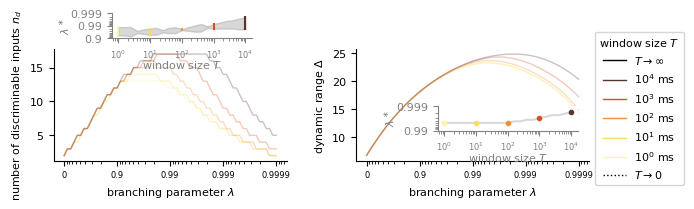

In [48]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'sigma': 0.02, # std of additive Gaussian noise
    'epsilon': 0.1, # error threshold for overlap
}
create_image(params, f'figures/fig_supplement_sigma={params["sigma"]}.pdf')

[1000]


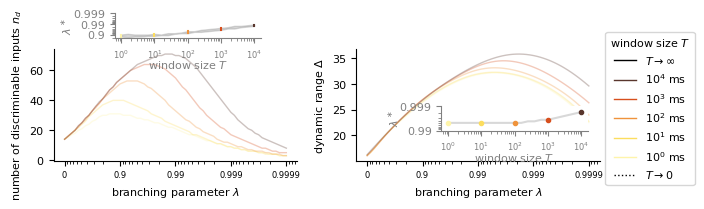

In [49]:
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'sigma': 0.005, # std of additive Gaussian noise
    'epsilon': 0.1, # error threshold for overlap
}
create_image(params, f'figures/fig_supplement_sigma={params["sigma"]}.pdf')

# Combine different sigma in single plot

In [60]:
# different plots for dynamic range and number of discriminable inputs 
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'epsilon': 0.1, # error threshold for overlap
    'seed': 1000, # specific seed
}
sigmas = [0.005, 0.01, 0.02]

In [63]:
# get data for all sigma
import sqlite3
con = sqlite3.connect('simulations.db')
cur = con.cursor()
# load dataframe from table
results = pd.read_sql_query(f"SELECT * FROM results WHERE N={params['N']} AND K={params['K']} AND mu={params['mu']} AND epsilon={params['epsilon']} AND seed={params['seed']}", con)
results.drop(columns=['N', 'K', 'mu', 'epsilon'], inplace=True)
con.close()
sigmas = np.sort(results.sigma.unique())
print("sigmas: ",sigmas)
seeds = results.seed.unique()
print("seeds: ",seeds)
windows = np.sort(results["window"].unique())
print("windows: ",windows)

sigmas:  [0.005 0.01  0.02 ]
seeds:  [1000]
windows:  [1.00000000e+00 1.58489319e+00 2.51188643e+00 3.98107171e+00
 6.30957344e+00 1.00000000e+01 1.58489319e+01 2.51188643e+01
 3.98107171e+01 6.30957344e+01 1.00000000e+02 1.58489319e+02
 2.51188643e+02 3.98107171e+02 6.30957344e+02 1.00000000e+03
 1.58489319e+03 2.51188643e+03 3.98107171e+03 6.30957344e+03
 1.00000000e+04]


In [82]:
focus_lam = [[] for i in range(len(focus_windows))]
focus_nds = [[] for i in range(len(focus_windows))]
focus_drs = [[] for i in range(len(focus_windows))]
lam_max_nds = [[] for i in range(len(windows))]
lam_max_drs = [[] for i in range(len(windows))]
# iterate over all windows
for (i,window) in enumerate(windows):
    # reduce dataframe to current window
    sel = results[results["window"] == window]
    for (s, sigma) in enumerate(sigmas):
        # load file
        filename = results[(results["window"] == window) & (results["sigma"] == sigma)].filename.values[0]
        # reduce filename to the path from ./results/
        filename = filename[filename.find("results/"):] 
        lams_data, drs_data, nds_data = np.loadtxt(f"{filename}", skiprows=1, unpack=True)
        # find lamda value of maximum from left and from right
        lam_max_nds[i].append([lams_data[np.argmax(nds_data)], lams_data[len(nds_data) - np.argmax(nds_data[::-1]) - 1]])
        lam_max_drs[i].append([lams_data[np.argmax(drs_data)], lams_data[len(drs_data) - np.argmax(drs_data[::-1]) - 1]])
        if not len(lams_data) > 60:
            print("problem with result {}_{}".format(window, seed))
        if window in focus_windows:
            focus_lam[focus_windows.index(window)].append(lams_data)
            focus_nds[focus_windows.index(window)].append(nds_data)
            focus_drs[focus_windows.index(window)].append(drs_data)

# for each window calculate the mean lower and upper lambda value
lam_max_nds = np.array(lam_max_nds)
lam_max_drs = np.array(lam_max_drs)
print(lam_max_nds[:,0,0])

# for nds plot range
lam_max_nds_lower = np.mean(lam_max_nds[:, :, 0], axis=1)
lam_max_nds_upper = np.mean(lam_max_nds[:, :, 1], axis=1)

# for drs calculate mean and variance (after mean over bounds, axis=2)
lam_max_drs_mean = np.mean(np.mean(lam_max_drs, axis=2), axis=1)
lam_max_drs_std = np.std(np.mean(lam_max_drs, axis=2), axis=1)

[0.84600735 0.82217206 0.84600735 0.84600735 0.86664786 0.86664786
 0.8845218  0.8845218  0.91340357 0.92501058 0.92501058 0.94376587
 0.94376587 0.95130325 0.95783035 0.96348259 0.9726158  0.9726158
 0.97946475 0.98221721 0.98460073]


## number of discriminable inputs

[Text(0, 0.1, '0.9'), Text(0, 0.01, '0.99'), Text(0, 0.001, '0.999')]

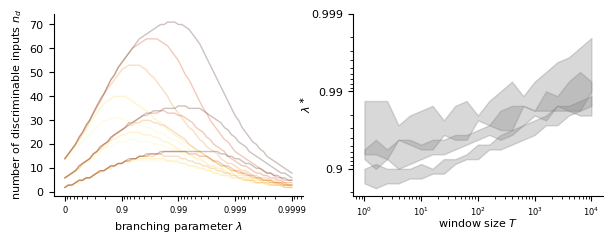

In [85]:
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 6
# set figure size to max width (Nature=18cm, APS=17.2cm)
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(1, 2, figsize=(18*cm, 6*cm))

for (i,window) in enumerate(focus_windows):
    for (s, sigma) in enumerate(sigmas):
        ax[0].plot(1-focus_lam[i][s], focus_nds[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)

ax[0].set_xlabel("branching parameter $\lambda$")
#ax[0].set_ylim(0, 59)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# plot bars between upper and lower bound
for (s, sigma) in enumerate(sigmas):
    upper = 1-lam_max_nds[:,s,0]
    lower = 1-lam_max_nds[:,s,1]
    ax[1].fill_between(windows, lower, upper, color="gray", alpha=0.3)

# remove boundaries top and right
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# x label
ax[1].set_xlabel("window size $T$", labelpad=-1)
ax[1].set_xscale("log")
# y label
ax[1].set_ylabel("$\lambda^\\ast$", labelpad=-1)
ax[1].set_yscale("log")
ax[1].invert_yaxis()
ax[1].set_yticks([1e-1, 1e-2, 1e-3])
ax[1].set_yticklabels(["0.9", "0.99", "0.999"])

## dynamic range

[Text(0, 0.01, '0.99'), Text(0, 0.001, '0.999')]

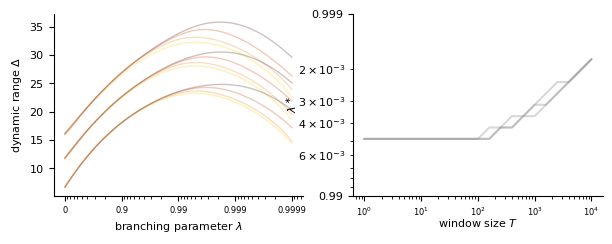

In [89]:
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 6
# set figure size to max width (Nature=18cm, APS=17.2cm)
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(1, 2, figsize=(18*cm, 6*cm))

for (i,window) in enumerate(focus_windows):
    for (s, sigma) in enumerate(sigmas):
        ax[0].plot(1-focus_lam[i][s], focus_drs[i][s], color=focus_colors[i], alpha=0.3, linewidth=1.0)

ax[0].set_xlabel("branching parameter $\lambda$")
#ax[0].set_ylim(0, 59)
ax[0].set_ylabel("dynamic range $\Delta$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# plot bars between upper and lower bound
for (s, sigma) in enumerate(sigmas):
    mean = 1-np.mean(lam_max_drs, axis=2)[:,s]
    ax[1].plot(windows, mean, color="gray", alpha=0.3)

# remove boundaries top and right
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# x label
ax[1].set_xlabel("window size $T$", labelpad=-1)
ax[1].set_xscale("log")
# y label
ax[1].set_ylabel("$\lambda^\\ast$", labelpad=-1)
ax[1].set_yscale("log")
ax[1].invert_yaxis()
ax[1].set_yticks([1e-2, 1e-3])
ax[1].set_yticklabels(["0.99", "0.999"])
plt.setp(ax[1].get_yminorticklabels(), visible=False);